# Sleep Score Withings Data

At home I use a sleep tracker from withing which every day yields a certain sleepscore. The sensors track heart rate, sleep duration, time in the sleephases, interruptions etc.
I will enrich that data with weather data (temperature during the night), weight data from my Garmin Smart Scale and seasonality data. The goal is to create an ML Model with which theoratically could predict good sleep vs bad sleep. A sleep score above 85 will be seen as good sleep.


* Create Dataset
* EDA

In [333]:
#Load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from datetime import datetime
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

## Create Dataset

In [334]:
#Read Data
df_weight = pd.read_csv('weight_garmin.csv')
df_sleep_stats = pd.read_csv('sleep_stats_withings.csv')
df_weather = pd.read_csv('weather.csv')
#This will be the variable to predict
df_sleepscore = pd.read_excel('sleepscore.xlsx')
df_seasonality = pd.DataFrame(columns = ['date','day','season'])

In [335]:
#Find relevant date range
start_date = df_sleepscore['date'].min()
end_date = df_sleepscore['date'].max()

#Create numpy array with daterange start to end

daterange = np.arange(start_date, end_date, np.timedelta64(1,'D'))

#Create empty dataframe with dates to join
df_date = pd.DataFrame()
df_date['date'] = daterange

df_date

,date
0,2023-02-13
1,2023-02-14
2,2023-02-15
3,2023-02-16
4,2023-02-17
...,...
251,2023-10-22
252,2023-10-23
253,2023-10-24
254,2023-10-25


#### Process Weight Data

In [336]:
### Process Weight
df_weight.head()

,Zeit,Gewicht,Veränderung,BMI,Körperfett,Skelettmuskelmasse,Knochenmasse,Körperwasser,Unnamed: 8
0,"Okt 24, 2023",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7:13 AM,79.6 kg,0.1 kg,24.8,22 %,33.7 kg,5.1 kg,56.9 %,NaN
2,"Okt 17, 2023",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8:26 AM,79.5 kg,1.1 kg,24.8,22.3 %,33.6 kg,5.0 kg,56.7 %,NaN
4,"Okt 16, 2023",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [337]:
#Weight dataframe shows date with nan values and then the actual values below with time measured

#Get the index of all dates, apply regex finding values with a year in it '\d{4}'
df_weight_dates = df_weight[df_weight['Zeit'].str.contains('\d{4}', regex = True)].Zeit.values
df_weight_dates_indices = df_weight[df_weight['Zeit'].str.contains('\d{4}', regex = True)].index


#Get the indices with values with date index + 1
df_weight_measurements_indices = list(df_weight_dates_indices + 1)
df_weight_measurements = df_weight.iloc[df_weight_measurements_indices,:]
df_weight_measurements = df_weight_measurements.rename(columns = {'Zeit':'date','Gewicht':'weight', 'BMI':'bmi', 'Körperfett':'bodyfat_perc','Skelettmuskelmasse':'musclemass_perc'}).copy()
df_weight_measurements.loc[:,'date'] = df_weight_dates

df_weight_measurements.reset_index(inplace = True)

df_weight_measurements = df_weight_measurements.loc[:,['date','weight','bmi','bodyfat_perc','musclemass_perc']]

#Process Date column, make date format

df_weight_measurements['date'] =  df_weight_measurements['date'].apply(lambda x: x.strip())

#Month dictionary
months_DE_EN = {'Okt': 'Oct', 'Mai':'May','Mrz':'Mar', 'Dez':'Dec'}

translated_dates = []
for val in df_weight_measurements['date'].values:
    month_translated = False
    for month in months_DE_EN:
        if month in val:
            val = val.replace(month,months_DE_EN[month])
            translated_dates.append(val)
            month_translated = True
    if month_translated == True:
        pass
    else:
        translated_dates.append(val)

df_weight_measurements['date'] = translated_dates
df_weight_measurements['date'] = pd.to_datetime(df_weight_measurements['date'],format='%b %d, %Y')

#Process Other columns

df_weight_measurements['weight'] = df_weight_measurements['weight'].apply(lambda x: x.replace(' kg',''))
df_weight_measurements['weight'] = pd.to_numeric(df_weight_measurements['weight'], errors='coerce')

df_weight_measurements['bmi'] = pd.to_numeric(df_weight_measurements['bmi'], errors='coerce')

df_weight_measurements['bodyfat_perc'] = df_weight_measurements['bodyfat_perc'].apply(lambda x: x.replace(' %',''))
df_weight_measurements['bodyfat_perc'] = pd.to_numeric(df_weight_measurements['bodyfat_perc'], errors='coerce')

df_weight_measurements['musclemass_perc'] = df_weight_measurements['musclemass_perc'].apply(lambda x: x.replace(' kg',''))
df_weight_measurements['musclemass_perc'] = pd.to_numeric(df_weight_measurements['musclemass_perc'], errors='coerce')

#Check if there are any NA
df_weight_measurements.isna().sum()

#Fill NA with previous values
df_weight_measurements['bodyfat_perc'] = df_weight_measurements['bodyfat_perc'].ffill()
df_weight_measurements['musclemass_perc'] = df_weight_measurements['musclemass_perc'].ffill()



In [338]:
#Check if there are any NA and types are correct
df_weight_measurements.info()
df_weight = df_weight_measurements

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             193 non-null    datetime64[ns]
 1   weight           193 non-null    float64       
 2   bmi              193 non-null    float64       
 3   bodyfat_perc     193 non-null    float64       
 4   musclemass_perc  193 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 7.7 KB


#### Process Weather Data

In [339]:
#Select street nearest to me and lets only take temperature
df_weather = df_weather[(df_weather['Standort']=='Zch_Schimmelstrasse') & (df_weather['Einheit']=='°C')]
#Only Take relevant columns and rename
df_weather = df_weather.loc[:,['Datum','Wert']]
df_weather = df_weather.rename(columns={'Datum':'date','Wert':'temp'})

In [340]:
#The relevant temperature for sleep should only be the temperature in the nighttime, we will take the average temperature from midnight till 7am, for this we need to create an hour column, then remove the hours we are not interested in, group by date and take the average
df_weather['date'] = pd.to_datetime(df_weather['date'])
df_weather['hour']= df_weather.loc[:,'date'].dt.hour
df_weather['date'] = df_weather.loc[:,'date'].dt.date

#Remove all hours that are not between 0 and 8 (inclusive)
df_weather = df_weather[(df_weather['hour']>=0)&(df_weather['hour']<=8)]


#Group and take average
df_weather = df_weather.loc[:,df_weather.columns != 'hour']
df_weather = df_weather.groupby('date').mean()

In [341]:
df_weather.reset_index(drop=False, inplace = True)
df_weather.temp = df_weather.temp.round(2)
df_weather

,date,temp
0,2023-01-01,13.53
1,2023-01-02,7.19
2,2023-01-03,8.19
3,2023-01-04,5.90
4,2023-01-05,10.60
...,...,...
297,2023-10-25,10.54
298,2023-10-26,12.49
299,2023-10-27,11.05
300,2023-10-28,10.40


In [342]:
#Check for nas
df_weather.isna().sum()

date    0
temp    7
dtype: int64

In [343]:
#Fill nas with previous value
df_weather['temp'] = df_weather['temp'].ffill()

In [344]:
df_weather['date'] = pd.to_datetime(df_weather['date'])

#### Process Sleep Stats

In [345]:
df_sleep_stats = df_sleep_stats.loc[:, ['bis', 'leicht (s)', 'tief (s)', 'rem (s)', 'wach (s)',
       'Aufwachen', 'Duration to sleep (s)', 'Average heart rate']]

In [346]:
df_sleep_stats.rename(columns= {'bis':'date', 'leicht (s)': 'lightsleep_sec', 'tief (s)' : 'deepsleep_sec', 'rem (s)':'remsleep_sec', 'wach (s)':'awake_sec',
       'Aufwachen':'interruptions', 'Duration to sleep (s)':'durationtosleep_sec', 'Average heart rate':'avg_hr'}, inplace = True)

In [347]:
df_sleep_stats['durationinbed_sec'] = df_sleep_stats['deepsleep_sec'] + df_sleep_stats['remsleep_sec'] + df_sleep_stats['lightsleep_sec'] + df_sleep_stats['awake_sec']

In [348]:
df_sleep_stats['date'] = [date[:10] for date in df_sleep_stats['date'].values]
df_sleep_stats['date'] = pd.to_datetime(df_sleep_stats['date'])

In [349]:
#Check if there are nas and check types
df_sleep_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238 entries, 0 to 237
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 238 non-null    datetime64[ns]
 1   lightsleep_sec       238 non-null    int64         
 2   deepsleep_sec        238 non-null    int64         
 3   remsleep_sec         238 non-null    int64         
 4   awake_sec            238 non-null    int64         
 5   interruptions        238 non-null    int64         
 6   durationtosleep_sec  238 non-null    int64         
 7   avg_hr               238 non-null    int64         
 8   durationinbed_sec    238 non-null    int64         
dtypes: datetime64[ns](1), int64(8)
memory usage: 16.9 KB


#### Process Seasonality Data

In [350]:
df_seasonality['date'] = daterange
df_seasonality['day'] = df_seasonality['date'].dt.day_name()
df_seasonality['month'] = df_seasonality['date'].dt.month
season = []
for month in df_seasonality['month'].values:
    if month in [3,4,5]:
        season.append('spring')
    elif month in [2,1,12]:
        season.append('winter')
    elif month in [6,7,8]:
        season.append('summer')
    else:
        season.append('autumn')

df_seasonality['season'] = season

df_seasonality = df_seasonality.loc[:,df_seasonality.columns!='month']


In [351]:
df_seasonality

,date,day,season
0,2023-02-13,Monday,winter
1,2023-02-14,Tuesday,winter
2,2023-02-15,Wednesday,winter
3,2023-02-16,Thursday,winter
4,2023-02-17,Friday,winter
...,...,...,...
251,2023-10-22,Sunday,autumn
252,2023-10-23,Monday,autumn
253,2023-10-24,Tuesday,autumn
254,2023-10-25,Wednesday,autumn


#### Process Sleepscore

In [352]:
df_sleepscore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257 entries, 0 to 256
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        257 non-null    datetime64[ns]
 1   sleepscore  211 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.1 KB


In [353]:
#46 days without sleepscore
df_sleepscore[df_sleepscore['sleepscore'].isna()]
# For simplicity reasons we will put the mean when data is missing
mean = df_sleepscore[df_sleepscore['sleepscore'].isna() == False].sleepscore.mean()
df_sleepscore= df_sleepscore.fillna(mean)

#### Join all dataframes

In [354]:
print(df_seasonality.dtypes)
print(df_weight.dtypes)
print(df_sleep_stats.dtypes)
print(df_weather.dtypes)
print(df_sleepscore.dtypes)

date      datetime64[us]
day               object
season            object
dtype: object
date               datetime64[ns]
weight                    float64
bmi                       float64
bodyfat_perc              float64
musclemass_perc           float64
dtype: object
date                   datetime64[ns]
lightsleep_sec                  int64
deepsleep_sec                   int64
remsleep_sec                    int64
awake_sec                       int64
interruptions                   int64
durationtosleep_sec             int64
avg_hr                          int64
durationinbed_sec               int64
dtype: object
date    datetime64[ns]
temp           float64
dtype: object
date          datetime64[ns]
sleepscore           float64
dtype: object


In [355]:
df = df_seasonality.merge(df_weight, how='left').merge(df_sleep_stats, how = 'left').merge(df_weather, how = 'left').merge(df_sleepscore, how = 'left')

In [356]:
df.isna().sum()

date                     0
day                      0
season                   0
weight                 126
bmi                    126
bodyfat_perc           126
musclemass_perc        126
lightsleep_sec          46
deepsleep_sec           46
remsleep_sec            46
awake_sec               46
interruptions           46
durationtosleep_sec     46
avg_hr                  46
durationinbed_sec       46
temp                     0
sleepscore               0
dtype: int64

In [357]:
#For all the weight measruments missing we will take previous value

df['weight'] = df['weight'].ffill()
df['bmi'] =  df['bmi'].ffill()
df['bodyfat_perc'] = df['bodyfat_perc'].ffill()
df['musclemass_perc'] = df['musclemass_perc'].ffill()

#for all the sleep tracking values missing we will take mean

df['lightsleep_sec'] = df['lightsleep_sec'].fillna(df['lightsleep_sec'].mean())
df['deepsleep_sec'] = df['deepsleep_sec'].fillna(df['deepsleep_sec'].mean())
df['remsleep_sec'] = df['remsleep_sec'].fillna(df['remsleep_sec'].mean())
df['awake_sec'] = df['awake_sec'].fillna(df['awake_sec'].mean())
df['interruptions'] = df['interruptions'].fillna(df['interruptions'].mean())
df['durationtosleep_sec'] = df['durationtosleep_sec'].fillna(df['durationtosleep_sec'].mean())
df['durationinbed_sec'] = df['durationinbed_sec'].fillna(df['durationinbed_sec'].mean())
df['avg_hr'] = df['avg_hr'].fillna(df['avg_hr'].mean())



In [358]:
df['sleepquality'] = (df['sleepscore'] >= 85).astype(int)

In [359]:
df = df.loc[:,df.columns!='sleepscore']
df = df.loc[:,df.columns!='date']

In [360]:
df


,day,season,weight,bmi,bodyfat_perc,musclemass_perc,lightsleep_sec,deepsleep_sec,remsleep_sec,awake_sec,interruptions,durationtosleep_sec,avg_hr,durationinbed_sec,temp,sleepquality
0,Monday,winter,80.0,25.0,22.7,33.8,15360.0,9900.0,9840.0,1500.0,2.0,1440.0,64.0,36600.0,2.88,1
1,Tuesday,winter,80.0,25.0,22.7,33.8,23040.0,4200.0,5940.0,3300.0,4.0,1020.0,62.0,36480.0,0.83,1
2,Wednesday,winter,80.6,25.2,22.4,34.0,14220.0,4380.0,7680.0,2160.0,0.0,2160.0,69.0,28440.0,-0.42,1
3,Thursday,winter,80.6,25.2,22.8,34.0,14340.0,4260.0,8520.0,660.0,0.0,660.0,69.0,27780.0,1.54,1
4,Friday,winter,80.4,25.1,23.0,33.9,19380.0,3660.0,4920.0,1200.0,0.0,1200.0,68.0,29160.0,8.18,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262,Sunday,autumn,79.5,24.8,22.3,33.6,16260.0,3480.0,5520.0,2700.0,0.0,2700.0,67.0,27960.0,10.31,0
263,Monday,autumn,79.5,24.8,22.3,33.6,22080.0,4860.0,3120.0,2220.0,1.0,2160.0,63.0,32280.0,10.15,0
264,Tuesday,autumn,79.6,24.8,22.0,33.7,16320.0,4320.0,4140.0,1440.0,1.0,1020.0,64.0,26220.0,11.70,0
265,Wednesday,autumn,79.6,24.8,22.0,33.7,14100.0,5460.0,5460.0,1920.0,0.0,1920.0,67.0,26940.0,10.54,0


## Exploratory Data Analysis

In [361]:
#Check distribution of sleepquality
df.sleepquality.value_counts()

sleepquality
0    148
1    119
Name: count, dtype: int64

In [362]:
df.dtypes

day                     object
season                  object
weight                 float64
bmi                    float64
bodyfat_perc           float64
musclemass_perc        float64
lightsleep_sec         float64
deepsleep_sec          float64
remsleep_sec           float64
awake_sec              float64
interruptions          float64
durationtosleep_sec    float64
avg_hr                 float64
durationinbed_sec      float64
temp                   float64
sleepquality             int64
dtype: object

In [363]:
#categorical
cat_vars = list(df.select_dtypes(include=['object']).columns.values)

#numerical
num_vars = list(df.select_dtypes(exclude=['object']).columns.values)

#### EDA Categorical Variables

In [364]:
for cat in cat_vars:
    print(df[cat].value_counts())

day
Wednesday    40
Monday       38
Tuesday      38
Thursday     38
Friday       38
Sunday       38
Saturday     37
Name: count, dtype: int64
season
summer    97
spring    96
autumn    57
winter    17
Name: count, dtype: int64


The days are evenly distributed, in the season variable there are not that many entries for winter

In [365]:
global_mean = df.sleepquality.mean()
print(global_mean)

0.44569288389513106


In [366]:
#Get average sleepquality for different days
df_days = df.loc[:,['day','sleepquality']].groupby('day').mean().reset_index()
df_days['diff'] = df_days['sleepquality'] - global_mean
df_days['risk'] = df_days['sleepquality']/global_mean
df_days

,day,sleepquality,diff,risk
0,Friday,0.500000,0.054307,1.121849
1,Monday,0.500000,0.054307,1.121849
2,Saturday,0.270270,-0.175423,0.606405
3,Sunday,0.473684,0.027991,1.062804
4,Thursday,0.421053,-0.024640,0.944715
5,Tuesday,0.500000,0.054307,1.121849
6,Wednesday,0.450000,0.004307,1.009664


Looks like I get the worst sleep on Saturdays

In [367]:
#Get average sleepquality for different days
df_seasons = df.loc[:,['season','sleepquality']].groupby('season').mean()
df_seasons['diff'] = df_seasons['sleepquality'] - global_mean
df_seasons['risk'] = df_seasons['sleepquality']/global_mean
df_seasons

,sleepquality,diff,risk
season,,,
autumn,0.263158,-0.182535,0.590447
spring,0.510417,0.064724,1.145221
summer,0.422680,-0.023012,0.948367
winter,0.823529,0.377837,1.847751


Hard to compare winter to the others, because there are not many entries, spring is better than summer though

In [368]:
from sklearn.metrics import mutual_info_score

def calculate_mi(series):
    return mutual_info_score(series, df.sleepquality)

df_mi = df[cat_vars].apply(calculate_mi)
df_mi = df_mi.sort_values(ascending=False).to_frame(name='MI')


display(df_mi.head())

,MI
season,0.037929
day,0.012010


#### EDA Numerical Variables

In [369]:
df.describe().round(1)

,weight,bmi,bodyfat_perc,musclemass_perc,lightsleep_sec,deepsleep_sec,remsleep_sec,awake_sec,interruptions,durationtosleep_sec,avg_hr,durationinbed_sec,temp,sleepquality
count,267.0,267.0,267.0,267.0,267.0,267.0,267.0,267.0,267.0,267.0,267.0,267.0,267.0,267.0
mean,78.0,24.3,21.0,33.3,15423.5,5392.1,6004.3,2491.8,0.9,1958.3,60.9,29311.8,13.8,0.4
std,1.0,0.3,0.6,0.3,4074.9,1814.2,2241.8,1071.5,0.9,829.2,4.5,6389.9,6.1,0.5
min,75.8,23.7,18.9,32.8,0.0,0.0,0.0,480.0,0.0,420.0,50.0,780.0,-0.5,0.0
25%,77.2,24.1,20.6,33.1,14160.0,4560.0,4830.0,1860.0,0.0,1440.0,58.0,28650.0,9.5,0.0
50%,77.8,24.3,20.9,33.3,15423.5,5392.1,6004.3,2491.8,0.9,1958.3,60.9,29400.0,14.5,0.0
75%,78.6,24.5,21.4,33.5,17520.0,6420.0,7380.0,2820.0,1.0,2280.0,63.0,32130.0,18.6,1.0
max,81.0,25.3,23.0,34.1,27060.0,10740.0,11520.0,8640.0,6.0,6180.0,82.0,42420.0,25.7,1.0


In [370]:
# Calculate correlations

df[num_vars].corrwith(df.sleepquality).to_frame('correlation').reset_index(drop=False).rename(columns = {'index':'variable'}).sort_values(by = 'correlation', ascending=False)#.to_frame('correlation').sort_values('correlation')

,variable,correlation
13,sleepquality,1.000000
6,remsleep_sec,0.479544
11,durationinbed_sec,0.307933
5,deepsleep_sec,0.209132
4,lightsleep_sec,0.184302
3,musclemass_perc,0.142851
0,weight,0.089434
1,bmi,0.085849
2,bodyfat_perc,0.011365
10,avg_hr,-0.054627


Correlation is not causation, but here we can see multiple hypothesis the align with theory, lower temperatur could mean better sleep

In [371]:
df.groupby(by='sleepquality')[num_vars].mean()

,weight,bmi,bodyfat_perc,musclemass_perc,lightsleep_sec,deepsleep_sec,remsleep_sec,awake_sec,interruptions,durationtosleep_sec,avg_hr,durationinbed_sec,temp,sleepquality
sleepquality,,,,,,,,,,,,,,
0,77.887838,24.311486,21.012162,33.265541,14751.367250,5052.552892,5042.160939,2704.602544,1.101932,2025.14125,61.076617,27550.683625,14.433581,0.0
1,78.063866,24.364706,21.026891,33.339496,16259.495798,5814.453782,7201.008403,2227.058824,0.731092,1875.12605,60.579832,31502.016807,12.981597,1.0


<Axes: >

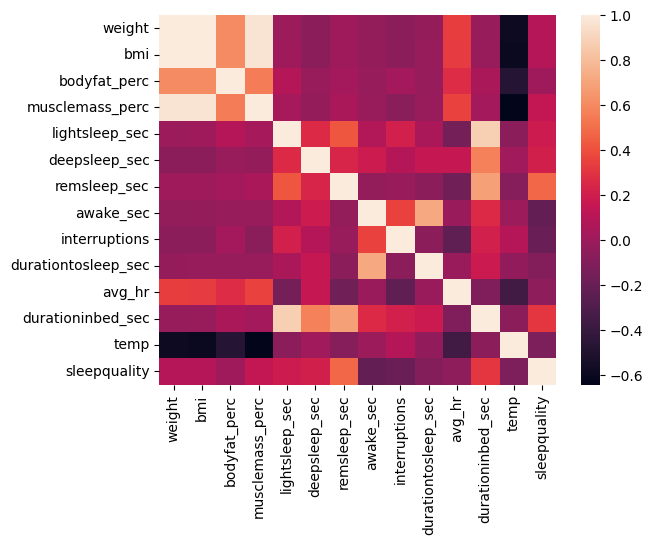

In [372]:
#Create some scatterplots
sns.heatmap(df[num_vars].corr())

The data from the scale are highly positively correlated, it might make sense to test model where we only include 1-2 scale variables. Temperature seem strongly negatively correlated with the scale metrics.

## Model Training - Logistic Regression Without Parameter Tuning

#### Train, Val, Test Split

In [373]:
from sklearn.model_selection import train_test_split
df_full_train_orig, df_test_orig = train_test_split(df, train_size=0.8, test_size=0.2, random_state=1)
df_train_orig, df_val_orig = train_test_split(df_full_train_orig, train_size=0.75, test_size=0.25, random_state=1)

df_full_train = df_full_train_orig.copy()
df_train = df_train_orig.copy()
df_val = df_val_orig.copy()
df_test = df_test_orig.copy()

#Check length of splits
print(len(df))
print(len(df_full_train), len(df_test), len(df_full_train + df_test))
print(len(df_train), len(df_val), len(df_train + df_val))


267
213 54 267
159 54 213


In [374]:
df_train.columns

Index(['day', 'season', 'weight', 'bmi', 'bodyfat_perc', 'musclemass_perc',
       'lightsleep_sec', 'deepsleep_sec', 'remsleep_sec', 'awake_sec',
       'interruptions', 'durationtosleep_sec', 'avg_hr', 'durationinbed_sec',
       'temp', 'sleepquality'],
      dtype='object')

In [375]:
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [376]:
df_train.columns

Index(['day', 'season', 'weight', 'bmi', 'bodyfat_perc', 'musclemass_perc',
       'lightsleep_sec', 'deepsleep_sec', 'remsleep_sec', 'awake_sec',
       'interruptions', 'durationtosleep_sec', 'avg_hr', 'durationinbed_sec',
       'temp', 'sleepquality'],
      dtype='object')

In [377]:
y_train = df_train.sleepquality
y_val = df_val.sleepquality
y_test = df_test.sleepquality



In [378]:
del df_train['sleepquality']
del df_val['sleepquality']

#### One Hot Encoding

In [379]:
from sklearn.feature_extraction import DictVectorizer

#Initiate dict vectorizer
dv = DictVectorizer(sparse=False) #fit_transform

#Transform data to dicts

train_dict = df_train.to_dict(orient='records')
val_dict = df_val.to_dict(orient='records')
test_dict = df_test.to_dict(orient='records')


#Fit the DictVectorizer

X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)
X_test = dv.transform(test_dict)


#### Fit Model

In [380]:
from sklearn.linear_model import LogisticRegression

model_1 = LogisticRegression()
model_1.fit(X_train, y_train)


/Users/kosta/.local/share/virtualenvs/homework-iNNgU132/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [381]:
#Create a table with coefficients
features = dv.get_feature_names_out()
df_coefficients = pd.DataFrame()
df_coefficients['feature'] = features
model_coefficients = model_1.coef_[0]
# model_coefficients = model_coefficients.transpose()
df_coefficients['coefficients'] = model_coefficients
df_coefficients.sort_values(by='coefficients', ascending=False).reset_index(drop=True)

,feature,coefficients
0,season=winter,0.009169
1,season=summer,0.006611
2,day=Wednesday,0.003326
3,day=Thursday,0.002735
4,day=Friday,0.002173
5,deepsleep_sec,0.001409
6,remsleep_sec,0.001338
7,durationtosleep_sec,0.000782
8,day=Tuesday,0.000525
9,durationinbed_sec,0.000466


#### Predict on Validation Data

In [382]:
#Predic
pred_val = model_1.predict(X_val)
pred_val_proba = model_1.predict_proba(X_val)[:,1]
df_pred = pd.DataFrame()
df_pred['y_val'] = y_val
df_pred['pred_val'] = pred_val
df_pred['correct_prediction'] = (df_pred['y_val']==df_pred['pred_val']).astype(int)
print(df_pred.head())
correct_pred_val = (df_pred.correct_prediction.mean() * 100).round(2)
print(f'{correct_pred_val}% correctly predicted in validation data set with model_1')

   y_val  pred_val  correct_prediction
0      0         1                   0
1      1         0                   0
2      1         1                   1
3      1         1                   1
4      0         0                   1
85.19% correctly predicted in validation data set with model_1


In [383]:
roc_auc_score(y_val,pred_val_proba).round(2)

0.86

85 Percent were correctly predicted with model_1. 

#### Train model with full train and use on y_test

In [384]:
df_full_train.reset_index(drop=True, inplace=True)

In [385]:
#df_fulltrain
y_full_train = df_full_train['sleepquality']
df_full_train_no_y = df_full_train.copy()
del df_full_train_no_y['sleepquality']

In [386]:
#One Hot Encoding
df_full_train_no_y_dict = df_full_train_no_y.to_dict(orient='records')
X_full_train = dv.transform(df_full_train_no_y_dict)

In [387]:
#Fit model
model_2 = LogisticRegression()
model_2.fit(X_full_train,y_full_train)

/Users/kosta/.local/share/virtualenvs/homework-iNNgU132/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [388]:
#Predict on test data
pred_test = model_2.predict(X_test)

In [389]:
pred_test_proba = model_2.predict_proba(X_test)

In [390]:
pred_test_proba_round = pred_test_proba[:,1].round(2)

In [391]:
df_pred_test = pd.DataFrame()
df_pred_test['y_test'] = y_test
df_pred_test['pred_test_proba'] = pred_test_proba_round
df_pred_test['pred_test'] = pred_test
df_pred_test['correct_prediction'] = (df_pred_test['y_test']==df_pred_test['pred_test']).astype(int)
correct_pred_test = (df_pred_test['correct_prediction'].mean() * 100).round(2)
print(f'{correct_pred_test}% correctly predicted in test data set with model_2')


87.04% correctly predicted in test data set with model_2


## Model Training - Logistic Regression With Parameter Tuning

1. Cross Validation to find the best parameter for C (Regularization, restricts how far away coefficients can be from 0)
2. When the correct C has been detected, find best threshold for that model, again with corss validation

In [392]:
#Create a training function

def train(df_train, y_train, C = 1.0):
    """Vectorize feature dataframe and train model"""
    df_train_dict = df_train.to_dict(orient='records')
    dv = DictVectorizer(sparse = False)
    X_train = dv.fit_transform(df_train_dict)
    model = LogisticRegression(C=C, max_iter=3000)
    model.fit(X_train, y_train)
    return dv, model


def predict(df, dv, model):
    """Vectorize features and make predictions"""
    df_dict = df.to_dict(orient='records')
    X = dv.transform(df_dict)
    y_pred = model.predict_proba(X)[:,1]
    return y_pred


In [393]:
C_options = [0.001, 0.01, 0.5, 1, 5, 10]

for c in tqdm(C_options):

    kf = KFold(n_splits=5, shuffle = True, random_state = 1)

    scores = []

    for train_idx, val_idx in kf.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]



        y_train = df_train['sleepquality'].values
        y_val = df_val['sleepquality'].values

        #Remove the y variable
        del df_train['sleepquality']
        del df_val['sleepquality']

        dv, model = train(df_train, y_train, C = c)

        y_pred = predict(df_val, dv, model)

        scores.append(roc_auc_score(y_val, y_pred))
    

    print('C=%s %.5f +- %.5f' % (c, np.mean(scores), np.std(scores)))


    

  0%|          | 0/6 [00:00<?, ?it/s]

C=0.001 0.87299 +- 0.03150
C=0.01 0.88386 +- 0.03216


 50%|█████     | 3/6 [00:00<00:00, 19.15it/s]

C=0.5 0.88282 +- 0.02714
C=1 0.88516 +- 0.03010
C=5 0.88734 +- 0.02710


100%|██████████| 6/6 [00:00<00:00, 19.65it/s]

C=10 0.88734 +- 0.02710


C = 5 and C = 10 have the best results

In [394]:
#Using it on th test data

dv, model = train(df_full_train_no_y, y_full_train, C = 5)
y_pred = predict(df_test, dv, model)
auc = roc_auc_score(y_test,y_pred)

print(f'The final logistic regression model applied on the test data has auc: {round(auc,2)}')

The final logistic regression model applied on the test data has auc: 0.89


A AUC scroe of 0.885 is reached. Increased performance slightly in comparison to non-tuned model. No feature were removed.

## Model Training - Tree Based Model

In [395]:
#recreating the original dataframes
df_full_train = df_full_train_orig.copy()
df_train = df_train_orig.copy()
df_val = df_val_orig.copy()
df_test = df_test_orig.copy()

### Model Training Decision Tree

In [396]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text

In [397]:
y_full_train = df_full_train.sleepquality
y_train = df_train.sleepquality
y_val = df_val.sleepquality
y_test = df_test.sleepquality

del df_full_train['sleepquality']
del df_train['sleepquality']
del df_val['sleepquality']
del df_test['sleepquality']


In [398]:
#Train single tree with default parameters
df_train_dict = df_train.to_dict(orient='records')

X_train = dv.fit_transform(df_train_dict)

dt = DecisionTreeClassifier()

dt.fit(X_train,y_train)

df_val_dict = df_val.to_dict(orient='records')

X_val = dv.transform(df_val_dict)

y_val_pred = dt.predict_proba(X_val)[:,1]

print('Decision Tree Performance: ',roc_auc_score(y_val,y_val_pred).round(2))


Decision Tree Performance:  0.76


### Model Training Decision Tree With Parameter Tuning

In [399]:
#Create different decision trees with variations in max_depth and min_sample_leaf





df_auc = pd.DataFrame(columns = ['depths','min_leaves','auc_score'])

#Instantiate dict vectorizer
dv = DictVectorizer(sparse=False)

#Transform df to list(dict)

df_full_train_dict = df_full_train.to_dict(orient='records')
df_train_dict = df_train.to_dict(orient='records')
df_val_dict = df_val.to_dict(orient='records')
df_test_dict = df_test.to_dict(orient='records')

#One Hot Encoding


X_fulltrain = dv.fit_transform(df_full_train_dict)
X_train = dv.fit_transform(df_train_dict)
X_val = dv.transform(df_val_dict)
X_test = dv.transform(df_test_dict)

depth_options = [2,3,4,5,6,7,8]
min_leaves_options = [5, 10, 15,20]


for depth in depth_options:
        for min_leaf in min_leaves_options:
                #Train
                dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=min_leaf)
                
                dt.fit(X_train,y_train)
                #Predict
                y_pred = dt.predict_proba(X_val)[:,1]
                #Evaluate
                auc = roc_auc_score(y_val, y_pred)

                
                row = [depth, min_leaf, round(auc,2)]
                
                df_auc.loc[len(df_auc)] = row



df_auc = df_auc.pivot(columns = 'depths', index = 'min_leaves', values = 'auc_score')


<Axes: xlabel='depths', ylabel='min_leaves'>

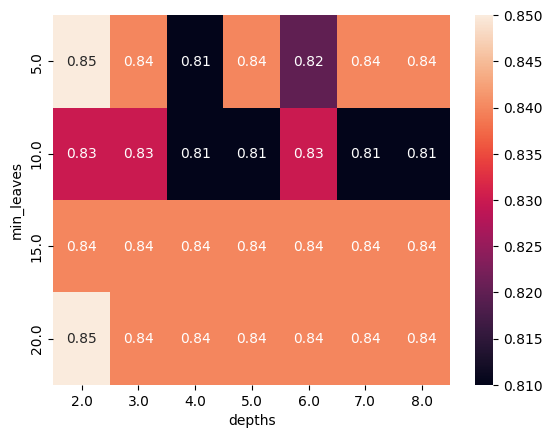

In [400]:
sns.heatmap(df_auc, annot=True)

We keep a decision tree with min_leaves = 5 and depth = 2, auc = 0.85


In [401]:
#Lets see if the AUC score changes drastically on the Test data

dt = DecisionTreeClassifier(max_depth=2, min_samples_leaf=5)
dt.fit(X_fulltrain,y_full_train)
y_pred = dt.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test,y_pred)

print(f'The final decision tree model applied on the test data has auc: {round(auc,2)}')

The final decision tree model applied on the test data has auc: 0.82


The auc gets worse with  -3%. Not a big shift, we keep the model

### Model Training Random Forest

In [402]:
from sklearn.ensemble import RandomForestClassifier

estimators = range(10,201,5)
depth_options = [2,3,4,5,6,7,8]
min_leaves_options = [5, 10, 15,20]

In [403]:
df_auc_rf = pd.DataFrame(columns= ['depth','n_estimator','auc'])

depth_options = [5,10,15]

#Tune max_depth
for depth in depth_options:
    for n_estimator in estimators:
        #Train
        rf = RandomForestClassifier(n_estimators=n_estimator, max_depth=depth)
        
        rf.fit(X_train,y_train)
        #Predict
        y_pred = rf.predict_proba(X_val)[:,1]
        #Evaluate
        auc = roc_auc_score(y_val, y_pred)

        
        row = [depth, n_estimator, round(auc,2)]
        
        df_auc_rf.loc[len(df_auc_rf)] = row


df_auc_rf

,depth,n_estimator,auc
0,5.0,10.0,0.89
1,5.0,15.0,0.87
2,5.0,20.0,0.87
3,5.0,25.0,0.89
4,5.0,30.0,0.84
...,...,...,...
112,15.0,180.0,0.88
113,15.0,185.0,0.88
114,15.0,190.0,0.89
115,15.0,195.0,0.89


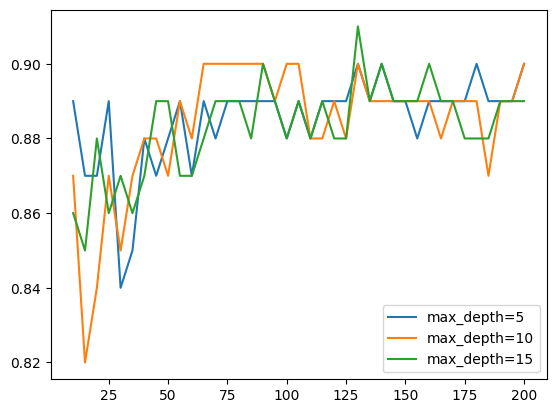

In [404]:
for d in df_auc_rf['depth'].unique():
    df_subset = df_auc_rf[df_auc_rf.depth == d]
    
    plt.plot(df_subset.n_estimator, df_subset.auc,
             label='max_depth=%d' % d)

plt.legend()

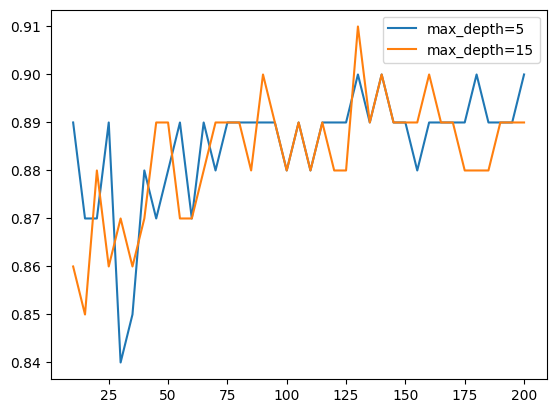

In [405]:
for d in [5,15]:
    df_subset = df_auc_rf[df_auc_rf.depth == d]
    
    plt.plot(df_subset.n_estimator, df_subset.auc,
             label='max_depth=%d' % d)

plt.legend()

We will choose max_depth = 5 as that curve seems to be above the max_depth 15 curve

In [406]:
depth =5

In [407]:
#Tune min_samples_lef
df_auc_rf = pd.DataFrame(columns= ['depth','n_estimator','auc'])


df_auc_rf.rename(columns={'depth':'min_leaves'}, inplace = True)

min_leaf_option = [2,5,8]

#Tune max_depth
for min_leaf in min_leaf_option:
    for n_estimator in estimators:
        #Train
        rf = RandomForestClassifier(n_estimators=n_estimator, max_depth=depth, min_samples_leaf=min_leaf)
        
        rf.fit(X_train,y_train)
        #Predict
        y_pred = rf.predict_proba(X_val)[:,1]
        #Evaluate
        auc = roc_auc_score(y_val, y_pred)

        
        row = [min_leaf, n_estimator, round(auc,2)]
        
        df_auc_rf.loc[len(df_auc_rf)] = row


df_auc_rf

,min_leaves,n_estimator,auc
0,2.0,10.0,0.87
1,2.0,15.0,0.87
2,2.0,20.0,0.88
3,2.0,25.0,0.90
4,2.0,30.0,0.89
...,...,...,...
112,8.0,180.0,0.90
113,8.0,185.0,0.91
114,8.0,190.0,0.89
115,8.0,195.0,0.90


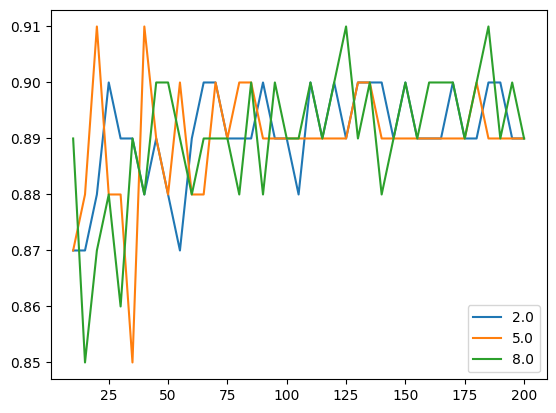

In [408]:
for cat in df_auc_rf['min_leaves'].unique():
    df_subset = df_auc_rf[df_auc_rf['min_leaves']==cat]
    plt.plot(df_subset.n_estimator,df_subset.auc,label = cat)

plt.legend()

Min_Leaf = 8 yields the best results

In [409]:
#Create final model

rf = RandomForestClassifier(n_estimators=200, max_depth=5, min_samples_leaf=8,random_state=1)

rf.fit(X_train,y_train)
#Predict
y_pred = rf.predict_proba(X_val)[:,1]
#Evaluate
auc = roc_auc_score(y_val, y_pred)
print(round(auc,3))

0.898


In [410]:
#Use full train to train model

rf.fit(X_fulltrain,y_full_train)
#Predict
y_pred = rf.predict_proba(X_test)[:,1]
#Evaluate
auc = roc_auc_score(y_test, y_pred)

print(f'The final random forest model applied on the test data has auc: {round(auc,2)}')

The final random forest model applied on the test data has auc: 0.91


In [411]:
y_pred = rf.predict_proba(X_test)[:,1]
#Evaluate
auc = roc_auc_score(y_test, y_pred)

print(f'The final random forest model applied on the test data has auc: {round(auc,2)}')

The final random forest model applied on the test data has auc: 0.91


In [416]:
y_pred[0]

0.4710584

### Model Training XGBoost

In [412]:
#Testing a GradientBoost Model with XGBoost
import xgboost as xgb


In [413]:
features = dv.get_feature_names_out().tolist()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)
xgb_params = {
    'eta': 0.1, 
    'max_depth': 5,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)
y_pred = model.predict(dval)
#roc_auc_score(y_val, y_pred)

In [414]:
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=features)
y_pred = model.predict(dtest)
auc = roc_auc_score(y_val, y_pred)
print(f'The final gradient boso model applied on the test data has auc: {round(auc,2)}')

The final gradient boso model applied on the test data has auc: 0.7


#### The tuned random forest model RandomForestClassifier(n_estimators=200, max_depth=5, min_samples_leaf=8,random_state=1) has the highest AUC and will be deployed